In [1]:
from qiskit import *
from qiskit_ibm_provider.ibm_provider import IBMProvider
from qiskit import pulse
from qiskit.pulse.library import Gaussian
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile, schedule as build_schedule

In [2]:
# Print out all the hardware available
provider = IBMProvider()
provider.backends()

[<IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_nairobi')>]

In [20]:
# Choose backend, in this case we choose nairobi
backend = provider.get_backend('ibm_nairobi')

In [65]:
config = backend.configuration()
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called ibm_nairobi, and is on version 1.3.2. It has 7 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['cx', 'id', 'rz', 'sx', 'x'].


In [66]:
props = backend.properties()
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              properties.frequency(qubit) * GHz))
describe_qubit(0, props)

Qubit 0 has a 
  - T1 time of 93.27835358907197 microseconds
  - T2 time of 31.380507102170558 microseconds
  - U2 gate error of 0.0003427343154599786
  - U2 gate duration of 35.55555555555556 nanoseconds
  - resonant frequency of 5.260500702181766 GHz


In [79]:
backend.properties().qubit_property(0)['anharmonicity'][0]

5260500702.181766

In [91]:
circ = QuantumCircuit(1)
circ.rx(np.pi/3,0)
transpiled_circ = transpile(circ, backend)  # Undefined Hadamard is replaced by U1
schedule = build_schedule(transpiled_circ, backend)

In [94]:
for i in range(3):
    print(i)

0
1
2


In [92]:
schedule

Schedule((0, ShiftPhase(-1.5707963268, DriveChannel(0))), (0, ShiftPhase(-1.5707963268, ControlChannel(1))), (0, Play(Drag(duration=160, sigma=40, beta=-0.4105538997425111, amp=0.06998959867460201, angle=-0.00422949453213747, name='X90p_d0'), DriveChannel(0), name='X90p_d0')), (160, ShiftPhase(-4.1887902048, DriveChannel(0))), (160, ShiftPhase(-4.1887902048, ControlChannel(1))), (160, Play(Drag(duration=160, sigma=40, beta=-0.4105538997425111, amp=0.06998959867460201, angle=-0.00422949453213747, name='X90p_d0'), DriveChannel(0), name='X90p_d0')), (320, ShiftPhase(-7.853981634, DriveChannel(0))), (320, ShiftPhase(-7.853981634, ControlChannel(1))), name="circuit-2040")

In [5]:
with pulse.build(backend, name='hadamard') as h_q0:
    pulse.play(Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0))
    #pulse.play(Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(1))

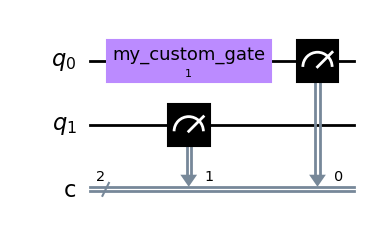

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit import transpile

circ = QuantumCircuit(2, 2)
custom_gate = Gate('my_custom_gate', 1 , [1])
# 3.14 is an arbitrary parameter for demonstration
circ.append(custom_gate, [0])
circ.measure([0, 1], [0, 1])

circ.draw('mpl')

In [10]:
circ.add_calibration(custom_gate, [0], h_q0)

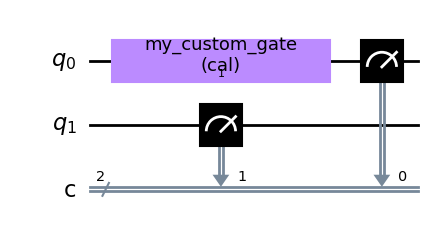

In [11]:
circ.draw('mpl')

In [12]:
job = execute(circ, backend, shots=4321, meas_level=1)

<JobStatus.QUEUED: 'job is queued'>

In [3]:
job1 = provider.retrieve_job("chdj3nkqqnv6prl27ejg")

In [11]:
cir0 = job1.circuits()[0]
cir1 = job1.circuits()[1]
cir2 = job1.circuits()[2]

In [28]:
cir1.remove_final_measurements()

In [32]:
#transpiled_cir1 = transpile(cir1, backend)  # Undefined Hadamard is replaced by U1
schedule_1 = build_schedule(cir1, backend)

In [33]:
schedule_1

Schedule((0, SetFrequency(5260500702.181766, DriveChannel(0))), (0, Play(Gaussian(duration=160, sigma=40.0, amp=0.13884080278518465, angle=0, name=''), DriveChannel(0))), name="circuit-88")

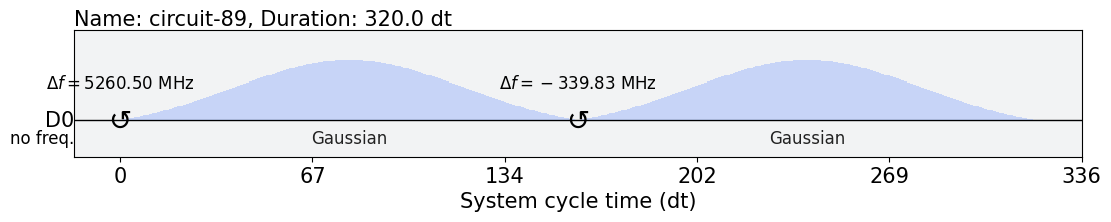

In [35]:
cir2.remove_final_measurements()
schedule_2 = build_schedule(cir2, backend)
schedule_2.draw()

In [14]:
res0 = job1.result().get_memory(cir0)
res1 = job1.result().get_memory(cir1)
res2 = job1.result().get_memory(cir2)

In [15]:
data_x_0 = np.real(res0)
data_y_0 = np.imag(res0)
data_x_1 = np.real(res1)
data_y_1 = np.imag(res1)
data_x_2 = np.real(res2)
data_y_2 = np.imag(res2)

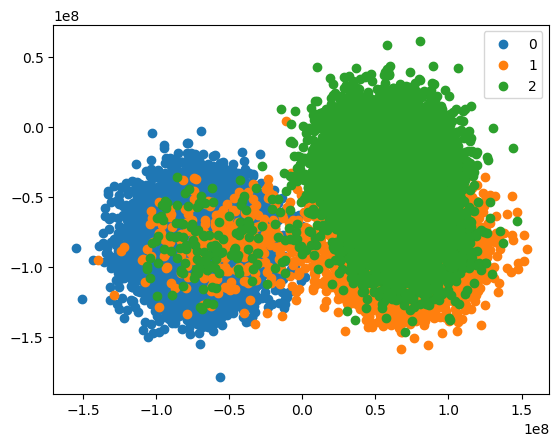

In [38]:
plt.scatter(data_x_0, data_y_0, label='0')
plt.scatter(data_x_1, data_y_1, label='1')
plt.scatter(data_x_2, data_y_2, label='2')
plt.legend()

plt.show()

In [31]:
job2 = provider.retrieve_job("chcir8oo51arsoe76ctg")

In [33]:
job2.result().data()

{'memory': [[-68981800.0, -83785000.0]]}

In [7]:
job.result()

NameError: name 'job' is not defined

In [8]:
# Create "hello world" -> Check if our job is able to run on a quantum computer
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

In [9]:
circuit = QuantumCircuit(qr, cr)

In [12]:
%matplotlib inline

In [13]:
circuit.draw()

q0_0: 
      
q0_1: 
      
c0: 2/

In [14]:
circuit.h(qr[0])

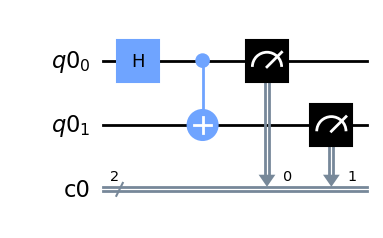

In [15]:
circuit.cx(qr[0], qr[1])
circuit.measure(qr, cr)
circuit.draw(output='mpl')

In [16]:
job = execute(circuit, backend=backend)

In [13]:
from qiskit.tools.monitor import job_monitor

In [ ]:
# job_monitor(job)

Job Status: job is queued (65)

In [1]:
from qiskit.tools.visualization import plot_histogram

In [ ]:
result = job.result()
plot_histogram(result.get_counts(circuit))